# Inverse Kinematics Simulation

In [1]:
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import math
import numpy as np

### Polar coordinate functions

In [2]:
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

### Calculate end-joint values from xyz position

In [3]:
def normalize_degree(theta):
    # Normalizes degree theta from -1.5pi to 1.5pi
    multiplier = 1.5
    normalized_theta = theta % (math.pi * multiplier)
    # Maintain the negative sign if the original angle is negative
    if theta < 0:
        normalized_theta -= math.pi * multiplier

    # Return angle
    return normalized_theta

def get_joints_from_xyz_rel(x, y, z, rx=0, ry=-math.pi/2, rz=0, initial_guess = (math.pi/2, math.pi/2, 0)):
    # Get limbs and offsets
    offset_x, offset_y, offset_z = (0, 0, 0.14)     # Tool offset
    l_bs, l1, l2, l3, l_wt = (0.1333, .425, .39225, .1267, .0997)    # Limb lengths
    
    # Calculate base angle and r relative to shoulder joint
    def calculate_theta(x, y, a):
        # Calculate if we need the + or - in our equations
        if (x>a and y>=0) or (x>-a and y<0):
            flip = 1
        elif (x<a and y>=0) or (x<-a and y<0):
            flip = -1
        else: 
            # Critical section (x=a, or x=-a). Infinite slope
            # Return 0 or 180 depending on sign
            return math.atan2(y, 0) - math.pi/2
        
        # Calculate tangent line y = mx + b
        if abs(a) != abs(x): # If there is no division by 0
            m = (x*y + math.sqrt(x*x*y*y-(x*x-a*a)*(y*y-a*a)))/(x*x-a*a)
        else: # Deal with edge case when x^2=a^2
            m = flip*(-a*a+y*y)/(a*y-flip*abs(a*y))
        b = flip * a * math.sqrt(1+m*m)

        # Calculate equivalent tangent point on circle
        cx = (-flip*m*b)/(1+m*m)
        cy = m*cx + flip*b

        # Calculate base angle, make angle negative if flip=1
        theta = math.atan2(cy, cx) + (-math.pi if flip==1 else 0)

        return theta 
    
    base_theta = calculate_theta(x, y, l_bs)
    cx, cy = l_bs*math.cos(base_theta), l_bs*math.sin(base_theta)
    r = math.sqrt((x-cx)**2 + (y-cy)**2) 


    # Formulas to find out joint positions for (r, z)
    def inv_kin_r_z(p):
        a, b, c = p            

        return (l1*math.cos(a) + l2*math.cos(a-b) + l3*math.cos(a-b-c) - r, # r
                l1*math.sin(a) + l2*math.sin(a-b) - l3*math.sin(a-b-c) - (l3*math.sin(a-b-c)) - (z + offset_z),  # z
                a-b-c) # wrist angle


    # Normalize angles
    base, shoulder, elbow, wrist1 = [normalize_degree(deg) for deg in [base_theta, *fsolve(inv_kin_r_z, initial_guess)]]

    # Return result
    return base, shoulder, elbow, wrist1, ry, rz

def get_joints_from_xyz_abs(x, y, z, rx=0, ry=-math.pi/2, rz=math.pi/2):
    joints = get_joints_from_xyz_rel(x, y, z, rx, ry, rz)

    # Joint offsets
    # Base, Shoulder, Elbow, Wrist
    inverse = [1, -1, 1, 1, 1, 1]
    offsets = [-math.pi/2, 0, 0, -math.pi/2, 0, 0]

    # Return adjusted joint positions
    robot_angles = [o+j*i for j, o, i in zip(joints, offsets, inverse)]

    return robot_angles

# Print degree rotation for each joint (robot angles)
[math.degrees(deg) for deg in get_joints_from_xyz_abs(-0.2, -0.5, 0.1)]

[82.5301003420473,
 -83.54918182551367,
 111.24503912126411,
 -117.69585729575046,
 -90.0,
 90.0]

### Simulate Arm and Joint Angles

In [4]:
def draw_arm_side_view(x, y, z, details=False):

    # Get joint angles
    l1, l2, l3 = .425, .39225, .1267
    offset_x, offset_y, offset_z = (0, 0, 0.14)
    r, theta = cartesian_to_polar(x, y)
    base, shoulder, elbow, wrist, _, _ = get_joints_from_xyz_rel(x, y, z)

    # Print angles
    if details:
        print('Target position (x,y,z):', x, y, z)
        print('R: ', round(math.sqrt(x**2+y**2),4))
        print('Angles (base, shoulder, elbow, wrist):', [round(math.degrees(i), 4) for i in [base, shoulder, elbow, wrist]])
        print('Robot Angles:', [round(math.degrees(i), 4) for i in get_joints_from_xyz_abs(x, y, z)])

    # Calculate each joint's endpoint position
    x1, y1 = polar_to_cartesian(l1, shoulder)
    x2, y2 = polar_to_cartesian(l2, shoulder-elbow)
    x2 += x1
    y2 += y1
    x3, y3 = polar_to_cartesian(l3, shoulder-elbow-wrist)
    x3 += x2
    y3 += y2 
    
    tx = x3
    ty = y3 - offset_z

    # Print each joint's endpoint position
    if details:
        print('elbow (x,y):', round(x1,3), round(y1,3))
        print('wrist (x,y):', round(x2,3), round(y2,3))
        print('tool  (x,y):', round(x3,3), round(y3,3))

    # Draw limbs
    plt.plot([0, x1], [0, y1], color='cyan', linewidth=7)
    plt.plot([x1, x2], [y1, y2], color='orange', linewidth=7)
    plt.plot([x2, x2+l3], [y2, y2], color='red', linewidth=7)
    plt.plot()

    # Draw toolpoint
    plt.plot([x3, tx], [y3, ty], color='black', linewidth=7)

    # Display angles
    plt.text(0, 0.02, f'{round(math.degrees(shoulder), 2)}°')
    plt.text(x1, y1+0.02, f'{round(math.degrees(elbow), 2)}°')
    plt.text(x2, y2+0.02, f'{round(math.degrees(wrist), 2)}°')

    # Display r arrow
    plt.annotate(f'', xy=(0, 0), xycoords='data', xytext=(x3, 0), textcoords='data', arrowprops={'arrowstyle': '<->'})
    plt.annotate(f'r={round(r,4)}', xy=(x2/2, 0.01), xycoords='data', xytext=(x2/2, 0), textcoords='offset points')

    # Display z arrow
    plt.annotate(f'', xy=(x3, 0), xycoords='data', xytext=(tx, ty), textcoords='data', arrowprops={'arrowstyle': '<->'})
    plt.annotate(f'z={round(ty,4)}', xy=(tx+0.01, ty/2), xycoords='data', xytext=(x3/2, 0), textcoords='offset points')
   
    # Display plot
    ax = plt.subplot(111)
    ax.spines[['right', 'top']].set_visible(False)
    plt.axis('equal')
    plt.show()

In [5]:
def draw_arm_top_view(x, y, z, details=False):
    # Get joint and position information
    angles = get_joints_from_xyz_rel(x, y, z)
    offset_x, offset_y, offset_z = (0, 0, 0.14)     # Tool offset
    l_bs, l1, l2, l3, l_wt = (0.1333, .425, .39225, .1267, .0997)    # Limb lengths
    cx, cy = l_bs*math.cos(angles[0]), l_bs*math.sin(angles[0]) # Base tangent point
    line_angle = math.pi/2+angles[0]

    if details:
        print('Angles:', [round(math.degrees(angle),3) for angle in angles])
        print(f'Circle position (cx, cy): ({round(cx, 3)}, {round(cy, 3)})')


    # Plot coordinate system
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

    # Target point
    # plt.plot(x, y, 'go')

    # Circle
    circle = plt.Circle((0, 0), l_bs, color='b', fill=False, linewidth=1)
    plt.plot([0, cx], [0, cy], color='b', linewidth=1)
    ax.add_patch(circle)

    # Draw limbs
    # Shoulder
    x1, y1 = polar_to_cartesian(l1*math.cos(angles[1]), line_angle)
    x1, y1 = cx+x1, cy+y1
    z1 = l1*math.sin(angles[1])
    plt.plot([cx, x1], [cy, y1], color='cyan', linewidth=3)

    # Elbow
    x2, y2 = polar_to_cartesian(l2*math.cos(angles[1]-angles[2]), line_angle)
    x2 += x1
    y2 += y1
    z2 = z1 + l2*math.sin(angles[1]-angles[2])
    plt.plot([x1, x2], [y1, y2], color='orange', linewidth=2)

    # Wrist
    x3, y3 = polar_to_cartesian(l3*math.cos(angles[1]-angles[2]-angles[3]), line_angle)
    x3 += x2
    y3 += y2
    z3 = z2 + l3*math.sin(angles[1]-angles[2]-angles[3]) 
    plt.plot([x2, x3], [y2, y3], color='red', linewidth=2)

    # Print joint positions
    if details:
        print(f'Shoulder (x, y, z): ({round(x1,3)}, {round(y1,3)}, {round(z1,3)})')
        print(f'Elbow    (x, y, z): ({round(x2,3)}, {round(y2,3)}, {round(z2,3)})')
        print(f'Wrist    (x, y, z): ({round(x3,3)}, {round(y3,3)}, {round(z3,3)})')

    # Display angle
    plt.text(0.01, -0.01-cy/abs(cy+0.00001)*0.02, f'{round(math.degrees(angles[0]), 2)}°', fontsize=7)

    # Display x arrow
    sign = x3/abs(x3)
    plt.annotate(f'', xy=(0, y3), xycoords='data', xytext=(x3, y3), textcoords='data', arrowprops={'arrowstyle': '<->'})
    plt.annotate(f'x={round(x3,3)}', xy=(-0.1-sign*0.13, y3-0.015), xycoords='data', xytext=(x2/2, 0), textcoords='offset points')

    # Display y arrow
    sign = y3/abs(y3)
    plt.annotate(f'', xy=(x3, 0), xycoords='data', xytext=(x3, y3), textcoords='data', arrowprops={'arrowstyle': '<->'})
    plt.annotate(f'y={round(y3,3)}', xy=((x3-0.1), -0.015-sign*0.03), xycoords='data', xytext=(x3/2, 0), textcoords='offset points')


    # Set axis limits and labels
    axis_limit = math.hypot(x, y)+.1
    plt.axis('square')
    plt.xlim(-axis_limit, axis_limit)
    plt.ylim(-axis_limit, axis_limit)

    # Adjust the position of axis labels
    plt.xlabel('+x', horizontalalignment='right', x=1.05)
    plt.ylabel('+y', verticalalignment='top', rotation=0, y=1.05)
    plt.show()

Angles: [-53.867, 89.583, 87.39, 2.193, -90.0, 0.0]
Circle position (cx, cy): (0.079, -0.108)
Shoulder (x, y, z): (0.081, -0.106, 0.425)
Elbow    (x, y, z): (0.398, 0.125, 0.44)
Wrist    (x, y, z): (0.5, 0.2, 0.44)


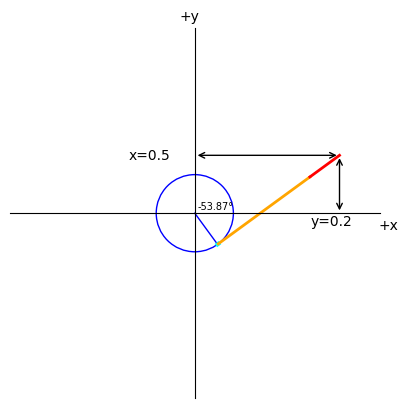

Target position (x,y,z): 0.5 0.2 0.3
R:  0.5385
Angles (base, shoulder, elbow, wrist): [-53.8671, 89.5827, 87.3895, 2.1932]
Robot Angles: [-143.8671, -89.5827, 87.3895, -87.8068, -90.0, 90.0]
elbow (x,y): 0.003 0.425
wrist (x,y): 0.395 0.44
tool  (x,y): 0.522 0.44


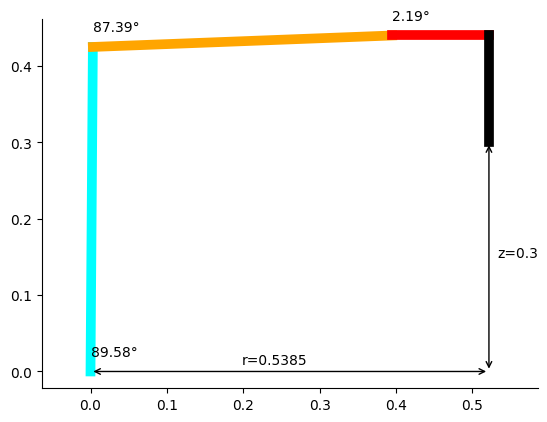

In [6]:
def draw_arm(x, y, z, details=False):
    draw_arm_top_view(x,y,z, details=details)
    draw_arm_side_view(x,y,z, details=details)

draw_arm(0.5,0.2,0.3, details=True)

In [10]:
def joint_positions(x, y, z):
    # Get joint and position information
    angles = get_joints_from_xyz_abs(x, y, z)
    offset_x, offset_y, offset_z = (0, 0, 0.14)     # Tool offset
    l_bs, l1, l2, l3, l_wt = (0.1333, .425, .39225, .1267, .0997)    # Limb lengths
    cx, cy = l_bs*math.cos(angles[0]), l_bs*math.sin(angles[0]) # Base tangent point
    line_angle = math.pi/2+angles[0]

    # Elbow
    x1, y1 = polar_to_cartesian(l1*math.cos(angles[1]), line_angle)
    x1, y1 = cx+x1, cy+y1
    z1 = l1*math.sin(angles[1])

    # Wrist
    x2, y2 = polar_to_cartesian(l2*math.cos(angles[1]-angles[2]), line_angle)
    x2 += x1
    y2 += y1
    z2 = z1 + l2*math.sin(angles[1]-angles[2])

    # Wrist 2
    x3, y3 = polar_to_cartesian(l3*math.cos(angles[1]-angles[2]-angles[3]), line_angle)
    x3 += x2
    y3 += y2
    z3 = z2 + l3*math.sin(angles[1]-angles[2]-angles[3]) 

    # Tool
    x4, y4 = polar_to_cartesian(offset_z*math.cos(angles[1]-angles[2]-angles[3]-angles[4]), line_angle)
    x4 += x3
    y4 += y3
    z4 = z3 + offset_z*math.sin(angles[1]-angles[2]-angles[3]-angles[4])


    positions = {
        'elbow': (x1, y1, z1),
        'wrist': (x2, y2, z2),
        'wrist2': (x3, y3, z3),
        'tool': (x4, y4, z4)
    }

    return positions

joint_positions(0.5,0.2,0.3)

{'elbow': (0.06441407671759522, -0.08297834710053949, 0.42498873000714044),
 'wrist': (0.3809831975755794, 0.14814654552767514, 0.44000000000002354),
 'wrist2': (0.4617483203289997, 0.20711259462904327, 0.44000000000002354),
 'tool': (0.4617483203289997, 0.20711259462904327, 0.5800000000000236)}